In [1]:
import math
import cs336_scaling.training_api as training_api
import cs336_scaling.common as common
import cs336_scaling.constants as constants
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import numpy as np
import time
import json

In [2]:
vocab_size = 32_000
batch_size = 128


def est_params(d_model: int, num_layers: int):
    return {
        "embed": 2 * vocab_size + d_model,
        "non_embed": 12 * num_layers * d_model**2,
        "total": 2 * vocab_size * d_model + 12 * num_layers * d_model**2,
    }


def chinchilla_params_for_c(c: int, tokens_per_param: int = 20):
    return math.sqrt(c / (6 * tokens_per_param))


def get_shape_for_n(
    n: int, aspect_ratio: int = 64, head_dim: int = 64, n_is_total: bool = False
):
    # (d, L, h, n)
    current_best_error = float("inf")
    current_best = None, None, None, None

    for d in range(64, 1537, 1):
        for L in range(2, 49):
            if d % head_dim != 0 or d / L != aspect_ratio:
                continue

            new_params = est_params(d, L)
            new_n = new_params["total"] if n_is_total else new_params["non_embed"]
            error = abs(new_n - n)

            if error < current_best_error:
                current_best_error = error
                current_best = (d, L, d // head_dim, new_n)

    return current_best


def get_shapes_by_ar_hd(aspect_ratio: float = 64, head_dim: int = 64):
    """Get a list of model shapes that have the required aspect ratio and
    head dimension, and are accepted by the training API."""
    shapes = []

    for d in range(64, 1537, 1):
        if d % head_dim != 0:
            continue

        for L in range(2, 49):
            if d / L != aspect_ratio:
                continue

            shapes.append([d, L, int(d / head_dim)])

    return shapes


In [3]:
compute_slices = [1e15, 3e15, 6e15, 1e16, 3e16, 6e16, 1e17, 3e17, 6e17, 1e18, 3e18, 6e18, 1e19]  # fmt: skip

In [4]:
tok_per_param_targets = [int(4 * 1.5**i) for i in range(9)]  # log-spaced from 4 to ~100

header = "_\t" + "\t".join([f"{target:>11.0f}" for target in tok_per_param_targets])

print(header)

for c in compute_slices:
    row = f"{c:.0e}\t"

    for tok_per_param in tok_per_param_targets:
        n_guess_total = int(chinchilla_params_for_c(c, tokens_per_param=tok_per_param))
        row += f"{n_guess_total:>11,}\t"

    print(row)

_	          4	          6	          9	         13	         20	         30	         45	         68	        102
1e+15	  6,454,972	  5,270,462	  4,303,314	  3,580,574	  2,886,751	  2,357,022	  1,924,500	  1,565,560	  1,278,274	
3e+15	 11,180,339	  9,128,709	  7,453,559	  6,201,736	  5,000,000	  4,082,482	  3,333,333	  2,711,630	  2,214,037	
6e+15	 15,811,388	 12,909,944	 10,540,925	  8,770,580	  7,071,067	  5,773,502	  4,714,045	  3,834,824	  3,131,121	
1e+16	 20,412,414	 16,666,666	 13,608,276	 11,322,770	  9,128,709	  7,453,559	  6,085,806	  4,950,737	  4,042,260	
3e+16	 35,355,339	 28,867,513	 23,570,226	 19,611,613	 15,811,388	 12,909,944	 10,540,925	  8,574,929	  7,001,400	
6e+16	 50,000,000	 40,824,829	 33,333,333	 27,735,009	 22,360,679	 18,257,418	 14,907,119	 12,126,781	  9,901,475	
1e+17	 64,549,722	 52,704,627	 43,033,148	 35,805,743	 28,867,513	 23,570,226	 19,245,008	 15,655,607	 12,782,749	
3e+17	111,803,398	 91,287,092	 74,535,599	 62,017,367	 50,000,000	 40,824,829	 33,333

In [5]:
1.52e18 - (6 * 3e15 + 6 * 6e15 + 6 * 1e16 + 5 * 3e16 + 4 * 6e16 + 4 * 1e17 + 2 * 3e17)

1.6e+16

In [6]:
C = 3e15
lr = 1e-3
head_dim = 64
aspect_ratio = 64

def print_shapes(shapes, c_slices=compute_slices):
    header = f"{'d'}\t{'L'}\t{'h'}\t{'n_ne':>10}\t{'n_tot':>10}\t"
    header += "\t".join([f"{slice:.0e}" for slice in c_slices])
    print(header)

    for shape in shapes:
        d, L, h = shape
        params = est_params(d, L)
        row = f"{d}\t{L}\t{h}\t{params['non_embed']:>10,}\t{params['total']:>10,}"
        for c in c_slices:
            tokens = c / (6 * params["total"])
            tokens_per_param = tokens / params["total"]
            row += f"\t{tokens_per_param:.1f}"
        print(row)

shapes = get_shapes_by_ar_hd(aspect_ratio=aspect_ratio, head_dim=head_dim)
print_shapes(shapes, c_slices=[c for c in compute_slices if c >= 3e16 and c <= 3e17])

d	L	h	      n_ne	     n_tot	3e+16	6e+16	1e+17	3e+17
128	2	2	   393,216	 8,585,216	67.8	135.7	226.1	678.4
192	3	3	 1,327,104	13,615,104	27.0	53.9	89.9	269.7
256	4	4	 3,145,728	19,529,728	13.1	26.2	43.7	131.1
320	5	5	 6,144,000	26,624,000	7.1	14.1	23.5	70.5
384	6	6	10,616,832	35,192,832	4.0	8.1	13.5	40.4
448	7	7	16,859,136	45,531,136	2.4	4.8	8.0	24.1
512	8	8	25,165,824	57,933,824	1.5	3.0	5.0	14.9
576	9	9	35,831,808	72,695,808	0.9	1.9	3.2	9.5
640	10	10	49,152,000	90,112,000	0.6	1.2	2.1	6.2
704	11	11	65,421,312	110,477,312	0.4	0.8	1.4	4.1
768	12	12	84,934,656	134,086,656	0.3	0.6	0.9	2.8
832	13	13	107,986,944	161,234,944	0.2	0.4	0.6	1.9
896	14	14	134,873,088	192,217,088	0.1	0.3	0.5	1.4
960	15	15	165,888,000	227,328,000	0.1	0.2	0.3	1.0
1024	16	16	201,326,592	266,862,592	0.1	0.1	0.2	0.7
1088	17	17	241,483,776	311,115,776	0.1	0.1	0.2	0.5
1152	18	18	286,654,464	360,382,464	0.0	0.1	0.1	0.4
1216	19	19	337,133,568	414,957,568	0.0	0.1	0.1	0.3
1280	20	20	393,216,000	475,136,000	0.0	0.0	0.1	0.2
1344	

In [7]:
time.time()

1746766131.2383559

In [8]:
import cs336_scaling.analyze as analyze

def get_v1_runs(sync_api: bool = False):
  return analyze.get_runs_after(start_time=1746596144.965823, sync_api=sync_api)

d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
64	4	4	   196,608	 4,292,608	9.0	27.1	54.3	90.4	271.3	542.7	904.5	2713.5	5427.0	9045.0	27134.9	54269.7	90449.5
80	5	5	   384,000	 5,504,000	5.5	16.5	33.0	55.0	165.0	330.1	550.2	1650.5	3301.0	5501.6	16504.9	33009.8	55016.4
96	6	6	   663,552	 6,807,552	3.6	10.8	21.6	36.0	107.9	215.8	359.6	1078.9	2157.8	3596.4	10789.2	21578.3	35963.9
Total flops used: 1.9649e+18


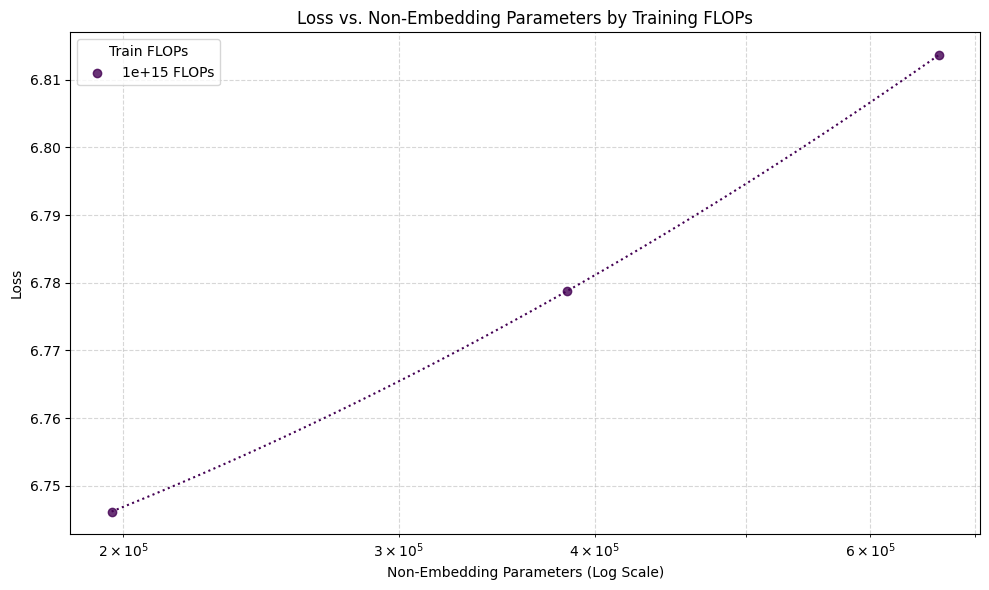

In [9]:
# C = 1e15
C = 1e15

shapes = [
    [64, 4, 4],
    [80, 5, 5],
    [96, 6, 6],
    # [112, 7, 7],
    # [128, 8, 8],
    # [144, 9, 9],
    # [160, 10, 10],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")


d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
64	4	4	   196,608	 4,292,608	9.0	27.1	54.3	90.4	271.3	542.7	904.5	2713.5	5427.0	9045.0	27134.9	54269.7	90449.5
80	5	5	   384,000	 5,504,000	5.5	16.5	33.0	55.0	165.0	330.1	550.2	1650.5	3301.0	5501.6	16504.9	33009.8	55016.4
96	6	6	   663,552	 6,807,552	3.6	10.8	21.6	36.0	107.9	215.8	359.6	1078.9	2157.8	3596.4	10789.2	21578.3	35963.9
112	7	7	 1,053,696	 8,221,696	2.5	7.4	14.8	24.7	74.0	147.9	246.6	739.7	1479.4	2465.6	7396.9	14793.7	24656.2
128	8	8	 1,572,864	 9,764,864	1.7	5.2	10.5	17.5	52.4	104.9	174.8	524.4	1048.7	1747.9	5243.7	10487.4	17479.0
144	9	9	 2,239,488	11,455,488	1.3	3.8	7.6	12.7	38.1	76.2	127.0	381.0	762.0	1270.1	3810.2	7620.3	12700.5
160	10	10	 3,072,000	13,312,000	0.9	2.8	5.6	9.4	28.2	56.4	94.1	282.2	564.3	940.5	2821.5	5643.0	9405.1
Total flops used: 1.9649e+18


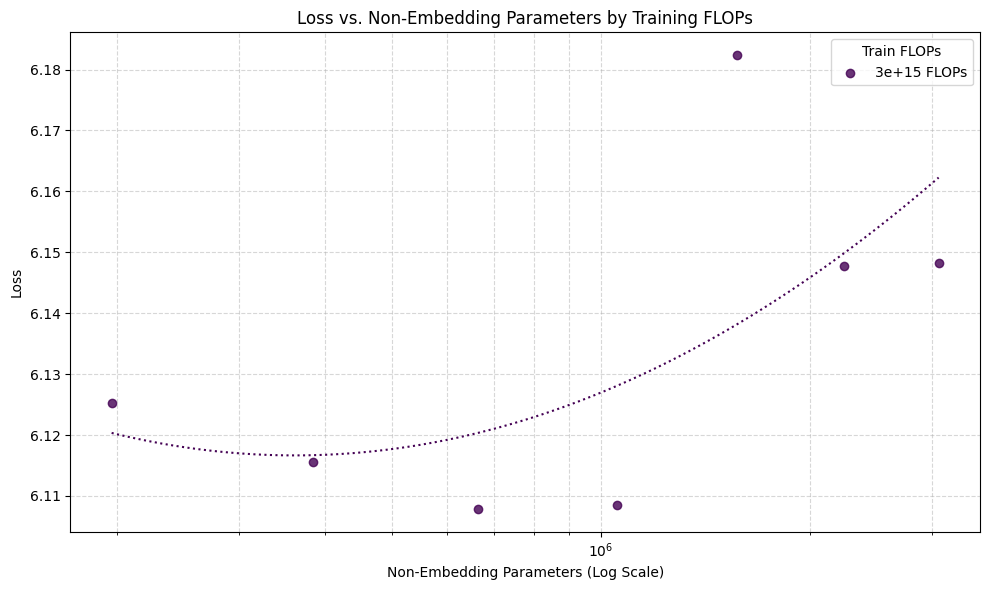

In [10]:
# C = 3e15
C = 3e15

shapes = [
    [64, 4, 4],
    [80, 5, 5],
    [96, 6, 6],
    [112, 7, 7],
    [128, 8, 8],
    [144, 9, 9],
    [160, 10, 10],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")


d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
64	2	2	    98,304	 4,194,304	9.5	28.4	56.8	94.7	284.2	568.4	947.4	2842.2	5684.3	9473.9	28421.7	56843.4	94739.0
96	3	3	   331,776	 6,475,776	4.0	11.9	23.8	39.7	119.2	238.5	397.4	1192.3	2384.6	3974.3	11923.0	23846.0	39743.4
128	4	4	   786,432	 8,978,432	2.1	6.2	12.4	20.7	62.0	124.1	206.8	620.3	1240.5	2067.5	6202.5	12405.1	20675.1
160	5	5	 1,536,000	11,776,000	1.2	3.6	7.2	12.0	36.1	72.1	120.2	360.6	721.1	1201.9	3605.6	7211.1	12018.6
192	6	6	 2,654,208	14,942,208	0.7	2.2	4.5	7.5	22.4	44.8	74.6	223.9	447.9	746.5	2239.4	4478.9	7464.8
224	7	7	 4,214,784	18,550,784	0.5	1.5	2.9	4.8	14.5	29.1	48.4	145.3	290.6	484.3	1452.9	2905.9	4843.1
256	8	8	 6,291,456	22,675,456	0.3	1.0	1.9	3.2	9.7	19.4	32.4	97.2	194.5	324.1	972.4	1944.9	3241.4
Total flops used: 1.9649e+18


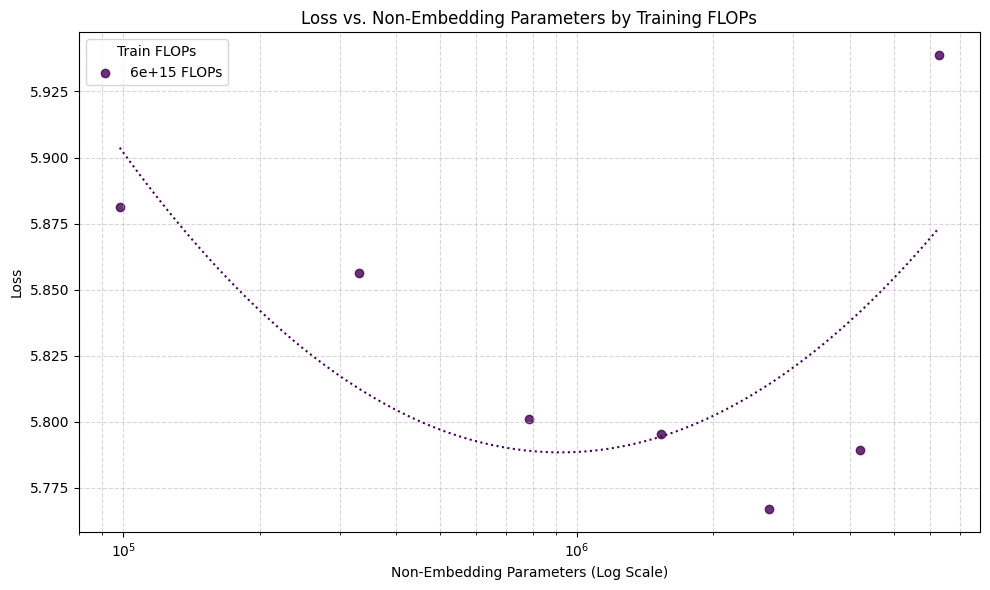

In [11]:
# C = 6e15
C = 6e15

shapes = [
    [64, 2, 2],
    [96, 3, 3],
    [128, 4, 4],
    [160, 5, 5],
    [192, 6, 6],
    [224, 7, 7],
    [256, 8, 8],
    # [288, 9, 9],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")

d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
192	6	6	 2,654,208	14,942,208	0.7	2.2	4.5	7.5	22.4	44.8	74.6	223.9	447.9	746.5	2239.4	4478.9	7464.8
224	7	7	 4,214,784	18,550,784	0.5	1.5	2.9	4.8	14.5	29.1	48.4	145.3	290.6	484.3	1452.9	2905.9	4843.1
256	8	8	 6,291,456	22,675,456	0.3	1.0	1.9	3.2	9.7	19.4	32.4	97.2	194.5	324.1	972.4	1944.9	3241.4
288	9	9	 8,957,952	27,389,952	0.2	0.7	1.3	2.2	6.7	13.3	22.2	66.6	133.3	222.2	666.5	1333.0	2221.6
Total flops used: 1.9649e+18


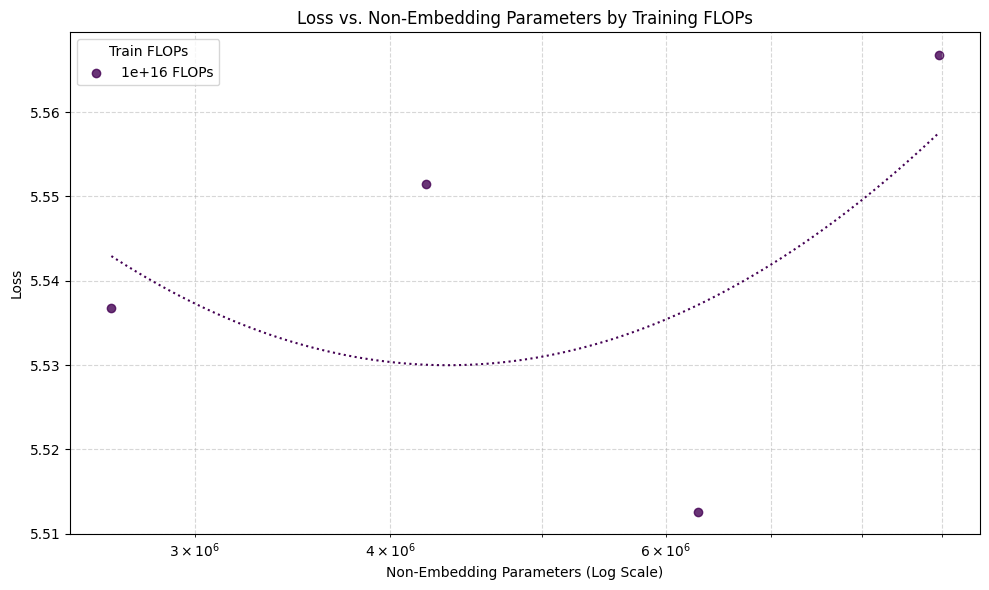

In [12]:
# C = 1e16
C = 1e16

shapes = [
    # [160, 5, 5],
    [192, 6, 6],
    [224, 7, 7],
    [256, 8, 8],
    [288, 9, 9],
    # [320, 10, 10],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")

d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
192	3	3	 1,327,104	13,615,104	0.9	2.7	5.4	9.0	27.0	53.9	89.9	269.7	539.5	899.1	2697.3	5394.6	8991.0
256	4	4	 3,145,728	19,529,728	0.4	1.3	2.6	4.4	13.1	26.2	43.7	131.1	262.2	437.0	1310.9	2621.8	4369.7
320	5	5	 6,144,000	26,624,000	0.2	0.7	1.4	2.4	7.1	14.1	23.5	70.5	141.1	235.1	705.4	1410.8	2351.3
384	6	6	10,616,832	35,192,832	0.1	0.4	0.8	1.3	4.0	8.1	13.5	40.4	80.7	134.6	403.7	807.4	1345.7
448	7	7	16,859,136	45,531,136	0.1	0.2	0.5	0.8	2.4	4.8	8.0	24.1	48.2	80.4	241.2	482.4	804.0
512	8	8	25,165,824	57,933,824	0.0	0.1	0.3	0.5	1.5	3.0	5.0	14.9	29.8	49.7	149.0	297.9	496.6
Total flops used: 1.9649e+18


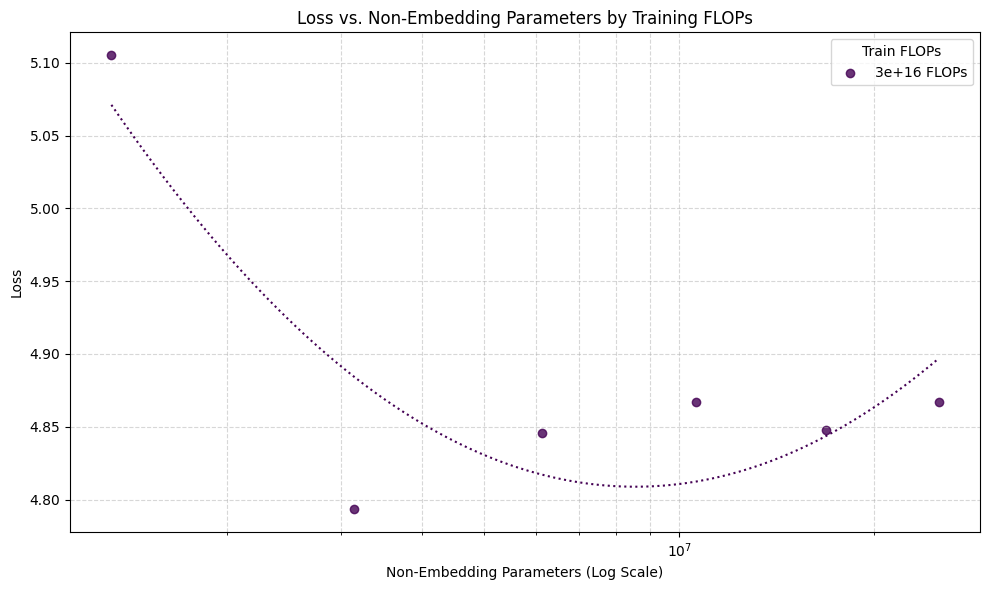

In [13]:
# C = 3e16
C = 3e16

shapes = [
    # [128, 2, 2],
    [192, 3, 3],
    [256, 4, 4],
    [320, 5, 5],
    [384, 6, 6],
    [448, 7, 7],
    [512, 8, 8],
    # [576, 9, 9],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")

d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
320	5	5	 6,144,000	26,624,000	0.2	0.7	1.4	2.4	7.1	14.1	23.5	70.5	141.1	235.1	705.4	1410.8	2351.3
384	6	6	10,616,832	35,192,832	0.1	0.4	0.8	1.3	4.0	8.1	13.5	40.4	80.7	134.6	403.7	807.4	1345.7
448	7	7	16,859,136	45,531,136	0.1	0.2	0.5	0.8	2.4	4.8	8.0	24.1	48.2	80.4	241.2	482.4	804.0
512	8	8	25,165,824	57,933,824	0.0	0.1	0.3	0.5	1.5	3.0	5.0	14.9	29.8	49.7	149.0	297.9	496.6
576	9	9	35,831,808	72,695,808	0.0	0.1	0.2	0.3	0.9	1.9	3.2	9.5	18.9	31.5	94.6	189.2	315.4
Total flops used: 1.9649e+18


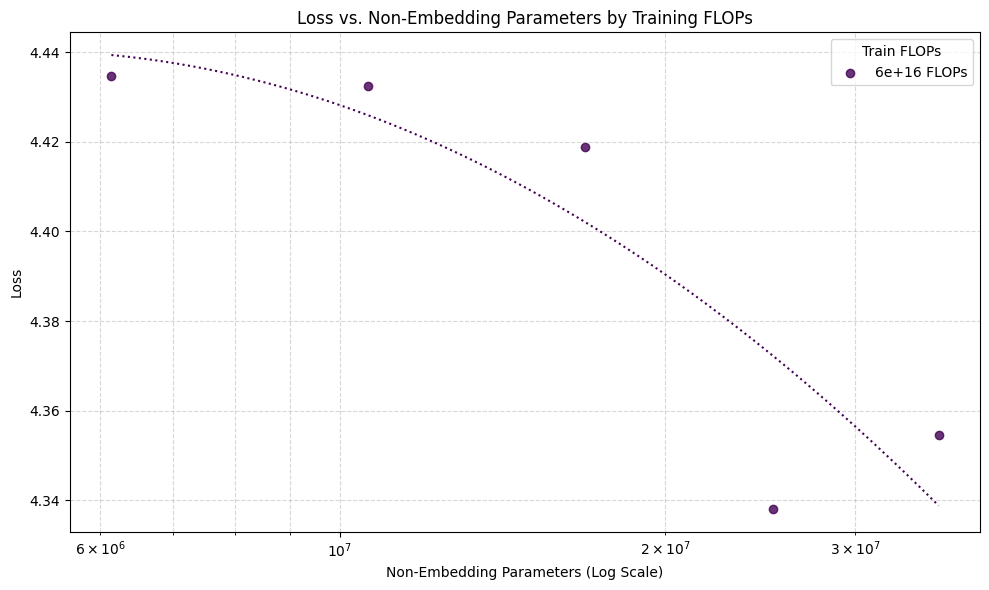

In [14]:
# C = 6e16
C = 6e16

shapes = [
    # [256, 4, 4],
    [320, 5, 5],
    [384, 6, 6],
    [448, 7, 7],
    [512, 8, 8],
    [576, 9, 9],
    # [640, 10, 10],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")

d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
512	8	8	25,165,824	57,933,824	0.0	0.1	0.3	0.5	1.5	3.0	5.0	14.9	29.8	49.7	149.0	297.9	496.6
576	9	9	35,831,808	72,695,808	0.0	0.1	0.2	0.3	0.9	1.9	3.2	9.5	18.9	31.5	94.6	189.2	315.4
640	10	10	49,152,000	90,112,000	0.0	0.1	0.1	0.2	0.6	1.2	2.1	6.2	12.3	20.5	61.6	123.2	205.3
Total flops used: 1.9649e+18


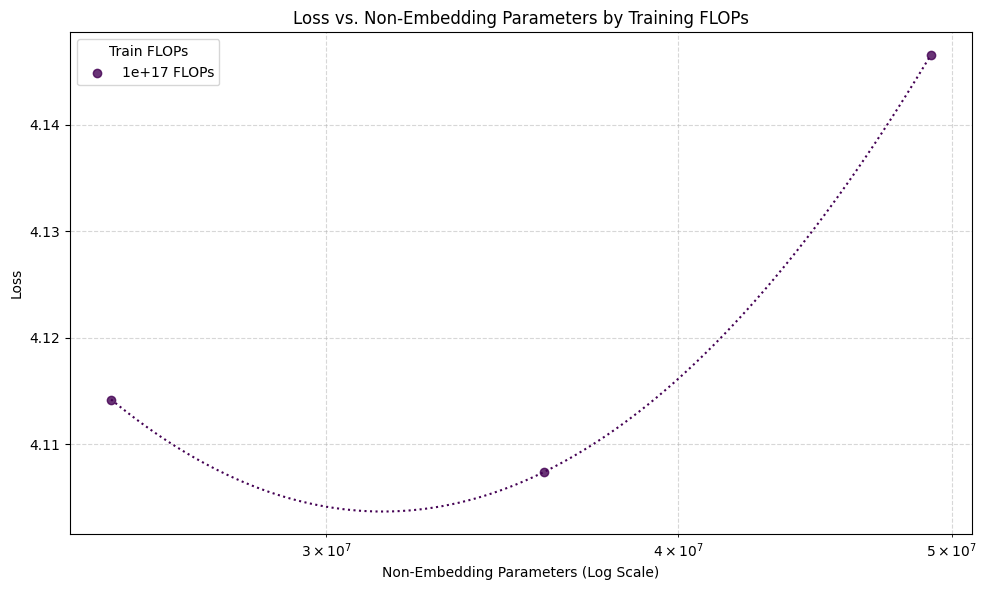

In [15]:
# C = 1e17
C = 1e17

shapes = [
    # [448, 7, 7],
    [512, 8, 8],
    [576, 9, 9],
    [640, 10, 10],
    # [704, 11, 11],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")

d	L	h	      n_ne	     n_tot	1e+15	3e+15	6e+15	1e+16	3e+16	6e+16	1e+17	3e+17	6e+17	1e+18	3e+18	6e+18	1e+19
704	11	11	65,421,312	110,477,312	0.0	0.0	0.1	0.1	0.4	0.8	1.4	4.1	8.2	13.7	41.0	81.9	136.6
768	12	12	84,934,656	134,086,656	0.0	0.0	0.1	0.1	0.3	0.6	0.9	2.8	5.6	9.3	27.8	55.6	92.7
Total flops used: 1.9649e+18


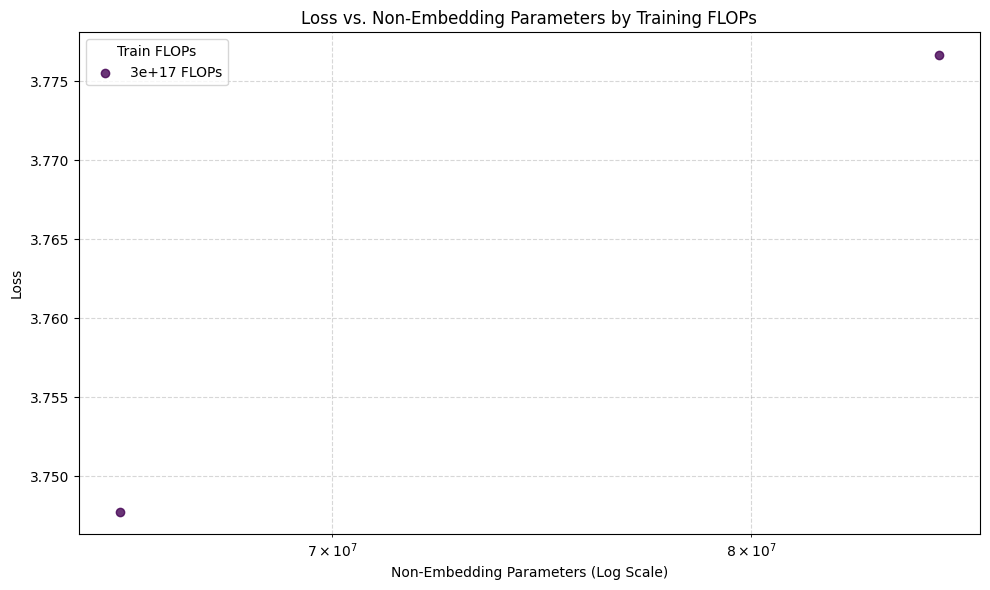

In [16]:
# C = 3e17
C = 3e17

shapes = [
    [704, 11, 11],
    [768, 12, 12],
]

print_shapes(shapes)

for shape in shapes:
    d, L, h = shape
    # training_api.get_loss(d, L, h, batch_size, lr, C)

runs = get_v1_runs(sync_api=True)
runs = [run for run in runs if run["train_flops"] == C]
analyze.plot_runs(runs=runs, best_n_per_c=10, outfile_suffix=f"_{C}")

print(f"Total flops used: {training_api.get_total_flops_used()}")

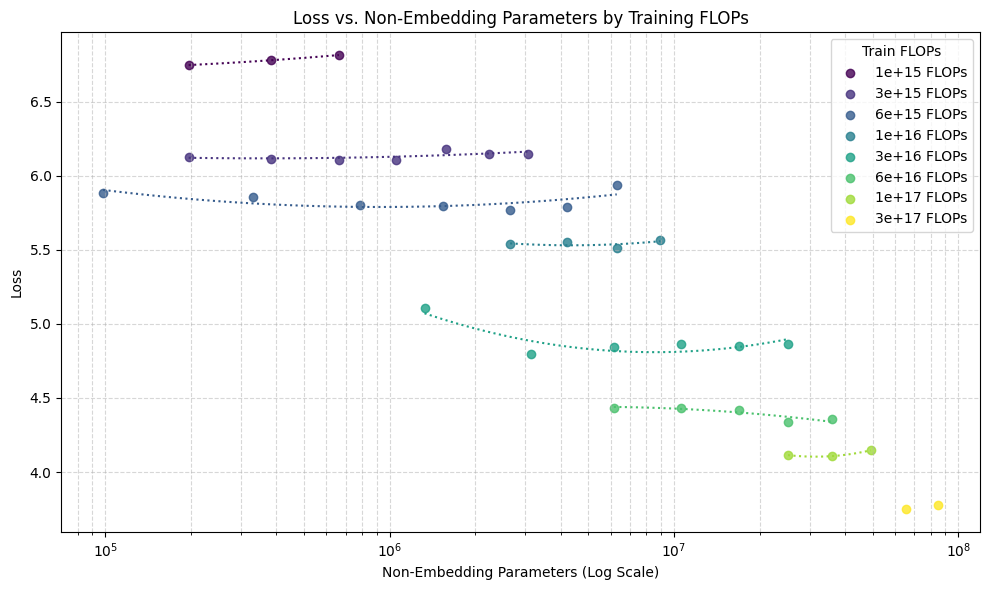

In [17]:
analyze.plot_runs(runs=get_v1_runs(), best_n_per_c=10, outfile_suffix="_v1_all")

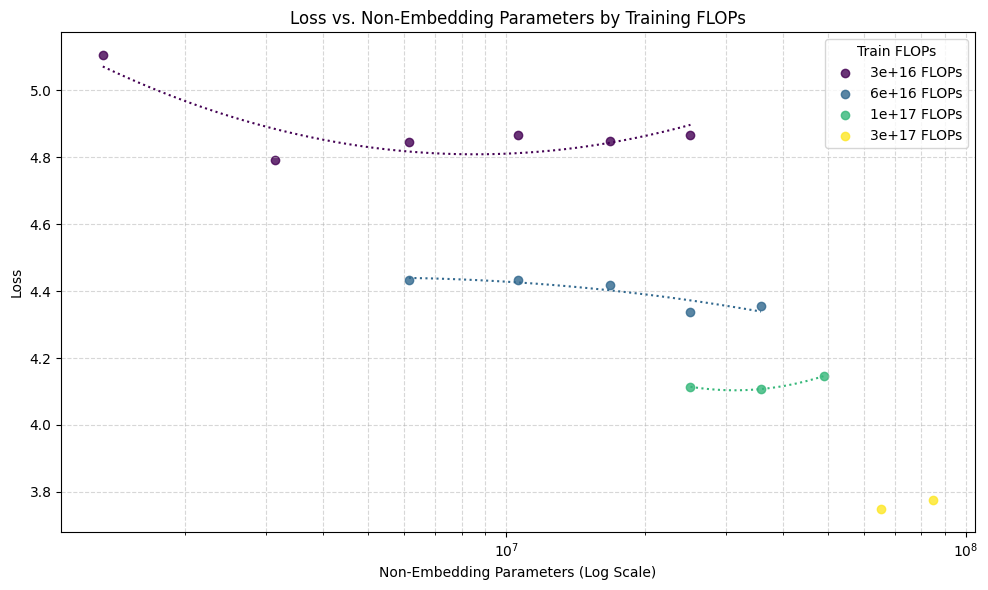

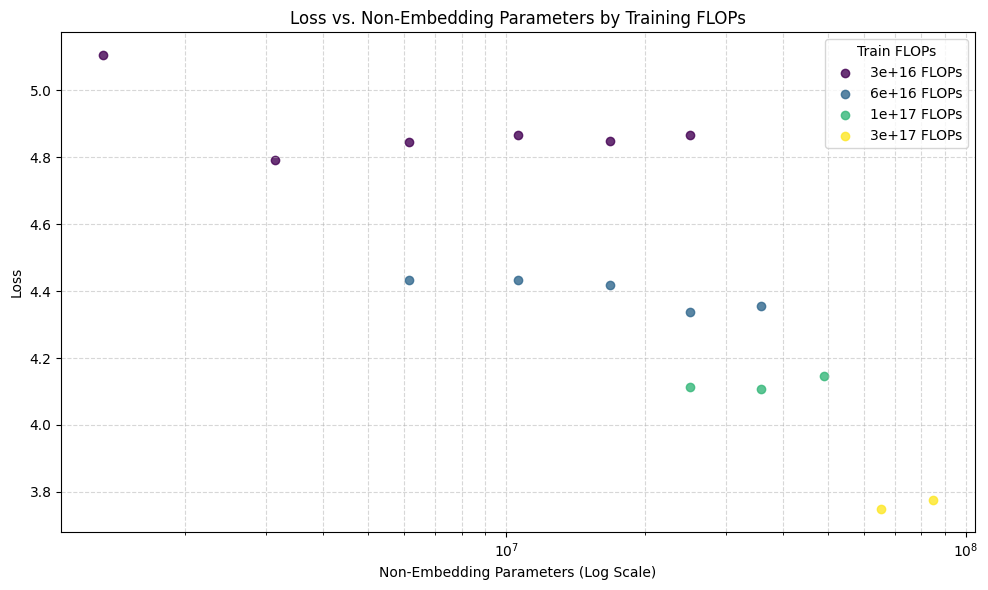

In [25]:
law_runs = get_v1_runs()
law_runs = [run for run in law_runs if run["train_flops"] >= 3e16]

analyze.plot_runs(runs=law_runs, best_n_per_c=10, outfile_suffix="_v1_law_runs_quad")
analyze.plot_runs(runs=law_runs, best_n_per_c=10, outfile_suffix="_v1_law_runs_all", quadratics=False)



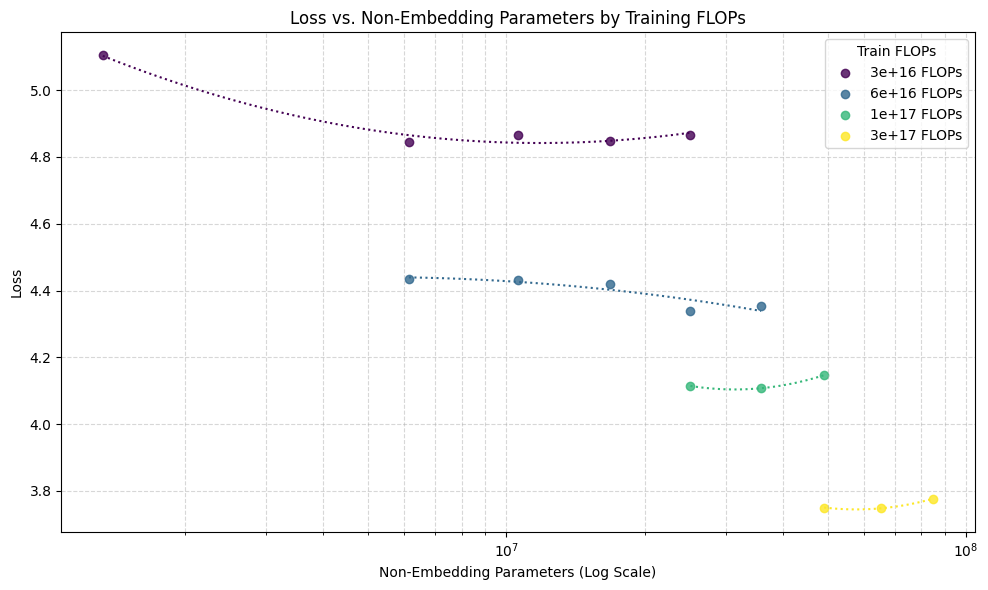

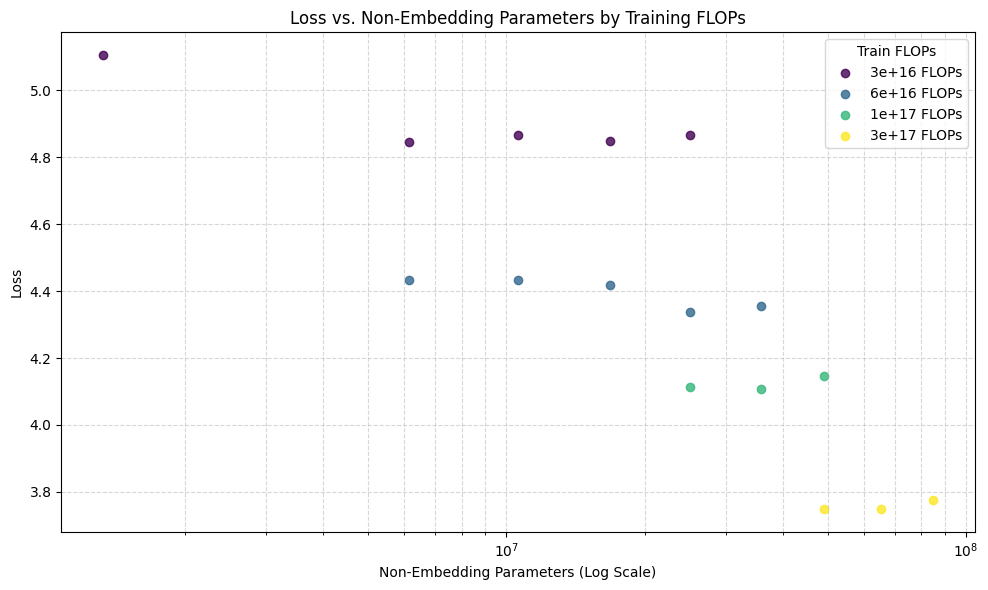

In [26]:
law_runs = get_v1_runs()
law_runs = [run for run in law_runs if run["train_flops"] >= 3e16]
law_runs = [run for run in law_runs if not (run["train_flops"] == 3e16 and run["loss"] == 4.79321509652062)]
law_runs.append(
    {
        "d_model": 640,
        "num_layers": 10,
        "num_heads": 10,
        "batch_size": 128,
        "learning_rate": 0.001,
        "train_flops": 3e17,
        "loss": 3.75,
        "est_n_total": 90112000,
        "est_n_non_embedding": 49152000,
        # "est_n_embed": 14336000,
        # "est_embed_ratio": 0.922509225092251,
        "est_tokens": 1072485.6132489897,
        "est_tokens_per_param": 6.2,
        "sync_time": 1746558909.372443,
    }
)
analyze.plot_runs(runs=law_runs, best_n_per_c=10, outfile_suffix="_v1_law_runs")
analyze.plot_runs(
    runs=law_runs, best_n_per_c=10, outfile_suffix="_v1_law_runs_filtered", quadratics=False
)


In [22]:
aspect_ratio = 64
head_dim = 64

shapes = get_shapes_by_ar_hd(aspect_ratio=aspect_ratio, head_dim=head_dim)
# print_shapes(shapes)

optima = {
    3e16: {"shape": [448, 7, 7], "params": {}, "loss": 4.847776889801025},
    6e16: {"shape": [512, 8, 8], "params": {}, "loss": 4.337969331286189},
    1e17: {"shape": [576, 9, 9], "params": {}, "loss": 4.1074066162109375},
    3e17: {"shape": [640, 10, 10], "params": {}, "loss": 3.75},  # guessed optimal shape
    # 3e17: {"shape": [704, 11, 11], "params": {}, "loss": 3.75},  # actual run
}

for c, optimum in optima.items():
    d, L, h = optimum["shape"]
    params = est_params(d, L)
    optimum["params"] = params

c_to_opt_non_embed = {
    c: optimum["params"]["non_embed"] for c, optimum in optima.items()
}

popt_ne, pcov_ne = optimize.curve_fit(
    analyze.power_law,
    list(c_to_opt_non_embed.keys()),
    list(c_to_opt_non_embed.values()),
)

c_to_opt_loss = {c: optimum["loss"] for c, optimum in optima.items()}

loss_floor = 1.69
losses = list(c_to_opt_loss.values())
loss_residuals = [loss - loss_floor for loss in losses]

popt_loss, pcov_loss = optimize.curve_fit(
    analyze.power_law,
    list(c_to_opt_loss.keys()),
    loss_residuals,
    p0=[1, 0.05],
    # bounds=((0, -1), (np.inf, 1.0)),
)

print(f"N = {popt_ne[0]:.2f} * C^{popt_ne[1]:.2f}")
print(f"L = {loss_floor} + {popt_loss[0]} * C^{popt_loss[1]}")

print("-" * 100)

print(
    f"{'c':>11}\t{'n_pred':>11}\t{'n_tot':>11}\t{'n_ne':>11}\t{'d':>7}\t{'L':>7}\t{'h':>7}\t{'tok/param':>11}\t{'loss':>8}"
)

compute_slices = [1e16, 3e16, 6e16, 1e17, 3e17, 6e17, 1e18, 3e18, 6e18, 1e19, 3e19, 6e19, 1e20]  # fmt: skip

empirical_optimal_ne = []
pred_optimal_ne = []

empirical_optimal_loss = []
pred_optimal_loss = []

for c in compute_slices:
    if c in optima:
        empirical_optimal_ne.append(optima[c]["params"]["non_embed"])
        empirical_optimal_loss.append(optima[c]["loss"])
    else:
        empirical_optimal_ne.append(None)
        empirical_optimal_loss.append(None)

    pred = analyze.power_law(c, popt_ne[0], popt_ne[1])
    loss = loss_floor + analyze.power_law(c, popt_loss[0], popt_loss[1])

    pred_optimal_ne.append(pred)
    pred_optimal_loss.append(loss)
    
    d, L, h, _ = get_shape_for_n(
        int(pred), aspect_ratio=aspect_ratio, head_dim=head_dim, n_is_total=False
    )
    params = est_params(d, L)
    tokens = c / (6 * params["total"])
    tokens_per_param = tokens / params["total"]
    row = f"{c:>11.0e}\t{int(pred):>11,}\t{params['total']:>11,}\t{params['non_embed']:>11,}\t{d:>7}\t{L:>7}\t{h:>7}\t{tokens_per_param:>11.1f}\t{loss:>8.2f}"
    print(row)


N = 2.77 * C^0.42
L = 1.69 + 4143.3231168743905 * C^-0.18973495740351917
----------------------------------------------------------------------------------------------------
          c	     n_pred	      n_tot	       n_ne	      d	      L	      h	  tok/param	    loss
      1e+16	 12,261,166	 35,192,832	 10,616,832	    384	      6	      6	        1.3	    5.51
      3e+16	 19,350,734	 45,531,136	 16,859,136	    448	      7	      7	        2.4	    4.79
      6e+16	 25,806,319	 57,933,824	 25,165,824	    512	      8	      8	        3.0	    4.41
      1e+17	 31,905,669	 72,695,808	 35,831,808	    576	      9	      9	        3.2	    4.16
      3e+17	 50,353,949	 90,112,000	 49,152,000	    640	     10	     10	        6.2	    3.69
      6e+17	 67,152,495	110,477,312	 65,421,312	    704	     11	     11	        8.2	    3.44
      1e+18	 83,024,056	134,086,656	 84,934,656	    768	     12	     12	        9.3	    3.28
      3e+18	131,029,663	192,217,088	134,873,088	    896	     14	     14	       13.

3
[1e+16, 3e+16, 6e+16, 1e+17, 3e+17, 6e+17, 1e+18, 3e+18, 6e+18, 1e+19]
[None, 16859136, 25165824, 35831808, 49152000, None, None, None, None, None]
[np.float64(12261166.1061189), np.float64(19350734.346076053), np.float64(25806319.58120074), np.float64(31905669.539327003), np.float64(50353949.21214686), np.float64(67152495.72984377), np.float64(83024056.59806885), np.float64(131029663.05635934), np.float64(174742379.22836977), np.float64(216042918.81425706)]


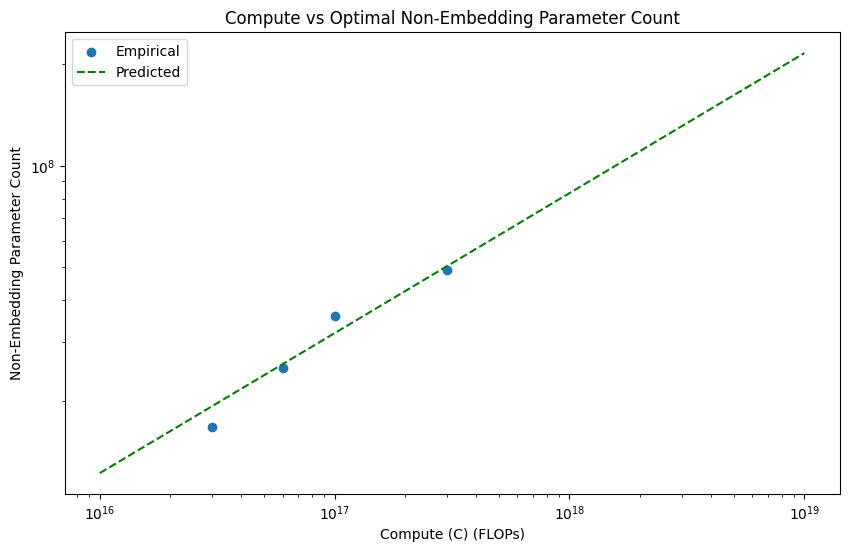

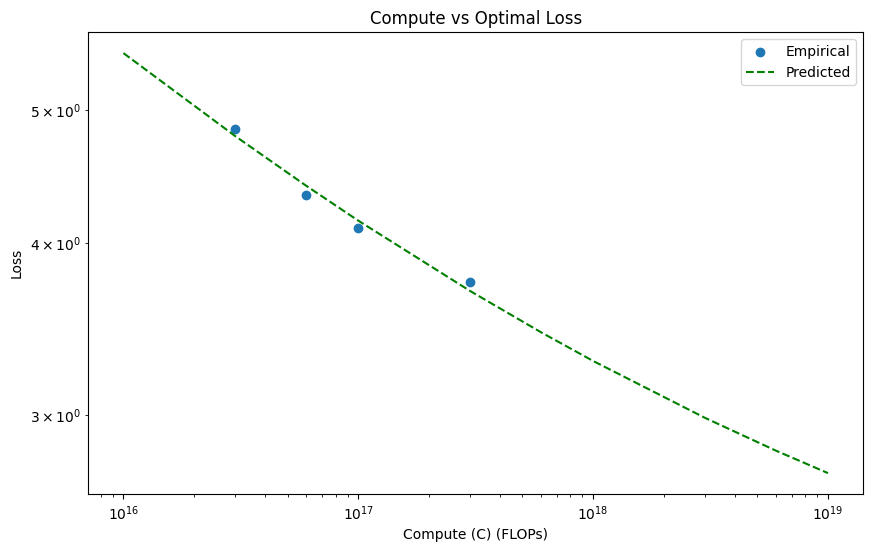

In [28]:
plot_compute_slices = [c for c in compute_slices if c <= 1e19]
diff =len(empirical_optimal_ne) - len(plot_compute_slices)
plot_empirical_optimal_ne = empirical_optimal_ne[:-diff]
plot_pred_optimal_ne = pred_optimal_ne[:-diff]

print(diff)

print(plot_compute_slices)
print(plot_empirical_optimal_ne)
print(plot_pred_optimal_ne)

plt.figure(figsize=(10, 6))
plt.scatter(plot_compute_slices, plot_empirical_optimal_ne, label='Empirical')
plt.plot(plot_compute_slices, plot_pred_optimal_ne, label='Predicted', color='green', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compute (C) (FLOPs)')
plt.ylabel('Non-Embedding Parameter Count')
plt.title('Compute vs Optimal Non-Embedding Parameter Count')
plt.legend()
plt.savefig('images/compute_vs_ne_params_fit.png')
plt.show()

plot_empirical_optimal_loss = empirical_optimal_loss[:-diff]
plot_pred_optimal_loss = pred_optimal_loss[:-diff]

plt.figure(figsize=(10, 6))
plt.scatter(plot_compute_slices, plot_empirical_optimal_loss, label='Empirical')
plt.plot(plot_compute_slices, plot_pred_optimal_loss, label='Predicted', color='green', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Compute (C) (FLOPs)')
plt.ylabel('Loss')
plt.title('Compute vs Optimal Loss')
plt.legend()
plt.savefig('images/compute_vs_loss_fit.png')
plt.show()